In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import matplotlib.pyplot as plt
import random
import scipy.io

In [2]:
import tensorflow.compat.v1 as tf
from tqdm import tqdm
import timeit 
tf.disable_v2_behavior()

2023-08-08 11:22:06.042454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 11:22:06.044676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 11:22:06.088143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 11:22:06.089080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 11:22:07.008910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
dat1 =pd.read_csv('data11.csv')
dat1.head()

,t,u1,u2
0,0.0,1.000000,0.000000
1,0.1,0.606531,0.372883
2,0.2,0.367879,0.563564
3,0.3,0.223130,0.647110
4,0.4,0.135335,0.668731


In [4]:
z1_new = np.array(dat1["u1"]).flatten()[:,None]
z2_new = np.array(dat1["u2"]).flatten()[:,None]
t_new = np.array(dat1["t"]).flatten()[:,None]

In [5]:
from scipy import interpolate

# Assuming that the 't_data' array is the independent variable and 'z1_data' and 'z2_data' are dependent variables
t_data = np.linspace(t_new.min(), t_new.max(), 100)[:, None]  # generating 500 points

# Interpolation for z1_data
f_z1 = interpolate.interp1d(t_new.flatten(), z1_new.flatten(), kind='cubic')  # 'cubic' for cubic spline interpolation
z1_data = f_z1(t_data)

# Interpolation for z2_data
f_z2 = interpolate.interp1d(t_new.flatten(), z2_new.flatten(), kind='cubic')  # 'cubic' for cubic spline interpolation
z2_data = f_z2(t_data)

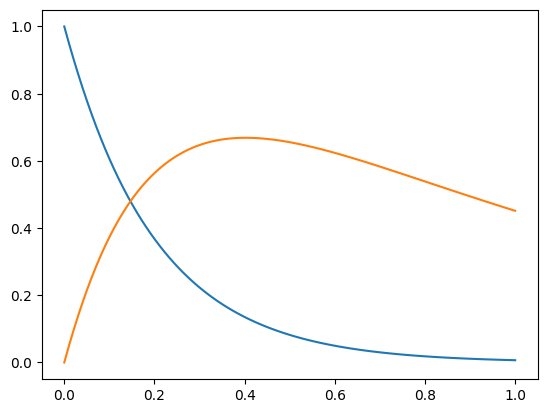

In [6]:
plt.plot(t_data, z1_data,"-")
plt.plot(t_data, z2_data,"-")

plt.show()

In [7]:
class PINN:
    # Initialize the class
    def __init__(self, t, z1, z2, layers, layers1, layers2):
        
        self.lb = t.min(0)
        self.ub = t.max(0)
        
        self.t = t
        
        self.z1 = z1
        self.z2 = z2
        
        self.layers = layers
        self.layers1 = layers1
        self.layers2 = layers2
        
        self.weights, self.biases = self.initialize_NN(layers)
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.z1_tf = tf.placeholder(tf.float32, shape=[None, self.z1.shape[1]])
        self.z2_tf = tf.placeholder(tf.float32, shape=[None, self.z2.shape[1]])               
        
        
        self.z1_pred, self.z2_pred = self.net_ASIR(self.t_tf)
        self.aa_pred = self.aa_net(self.t_tf)
        self.bb_pred = self.bb_net(self.t_tf)
        
        self.l1, self.l2 = self.net_l(self.t_tf)
        
        
        self.loss = tf.reduce_sum(tf.square(self.z1_tf - self.z1_pred)) + \
                    tf.reduce_sum(tf.square(self.z2_tf - self.z2_pred)) + \
                    tf.reduce_sum(tf.square(self.l1)) + \
                    tf.reduce_sum(tf.square(self.l2))
            
        
        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        #xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        xavier_stddev = 1/2*(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers, weights, biases):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def neural_net1(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_ASIR(self, t):
        ASIR = self.neural_net(t, self.layers, self.weights, self.biases)
        z1 = ASIR[:,0:1]
        z2 = ASIR[:,1:2]
        
        return z1, z2
    
    def aa_net(self,t):
        aa = self.neural_net1(t, self.layers1, self.weights1, self.biases1)
        alp = aa
        return alp
    
    def bb_net(self,t):
        bb = self.neural_net2(t, self.layers2, self.weights2, self.biases2)
        blp = bb
        return blp
    
    
    
    def net_l(self, t):
        z1, z2 = self.net_ASIR(t)
        aa = self.aa_net(t)
        bb = self.bb_net(t)
        
        z1_t = tf.gradients(z1, t)[0]
        z2_t = tf.gradients(z2, t)[0]
        
        
        
        l1 = z1 - (tf.exp(-aa*t))
        l2 = z2 - (5/4* tf.exp(-aa*t)*(-bb + tf.exp(4*t)))
        
        return l1, l2 
    
    
        
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.z1_tf: self.z1, self.z2_tf: self.z2}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                start_time = timeit.default_timer()
                
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        z1_star = self.sess.run(self.z1_pred, tf_dict)
        z2_star = self.sess.run(self.z2_pred, tf_dict)
        aa_star = self.sess.run(self.aa_pred, tf_dict)
        bb_star = self.sess.run(self.bb_pred, tf_dict)
        
        return z1_star, z2_star, aa_star, bb_star
        


In [8]:
niter = 90000  # number of Epochs
layers = [1, 40, 2]
layers1 = [1, 40, 1]
layers2 = [1, 40, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2)
model.train(niter)



Device mapping: no known devices.


2023-08-08 11:22:08.241463: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 11:22:08.621030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-08 11:22:08.624481: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:22:08.624500: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:22:08.624506: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 90000/90000 [00:40<00:00, 2208.93it/s]


In [9]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred = model.predict(t_data)

In [10]:
dat11 =pd.read_csv('data11.csv')
dat11.head()

,t,u1,u2
0,0.0,1.000000,0.000000
1,0.1,0.606531,0.372883
2,0.2,0.367879,0.563564
3,0.3,0.223130,0.647110
4,0.4,0.135335,0.668731


In [11]:
z11_data = np.array(dat11["u1"]).flatten()[:,None]
z21_data = np.array(dat11["u2"]).flatten()[:,None]
t1_data = np.array(dat11["t"]).flatten()[:,None]

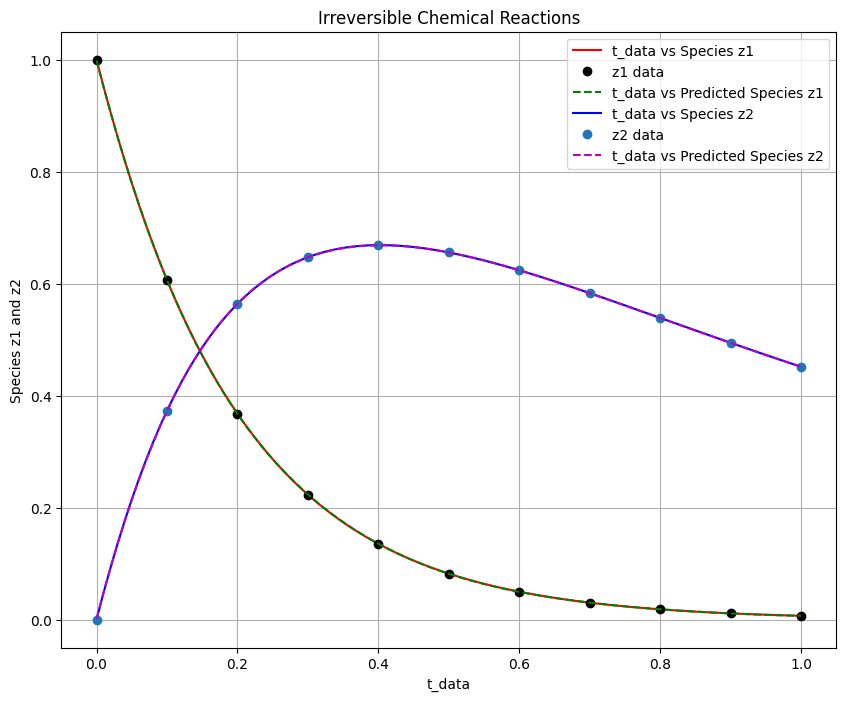

In [12]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,z1_data,'r')
plt.plot(t1_data,z11_data,'ko')
plt.plot(t_data,z1_pred,'g--')

plt.plot(t_data,z2_data,'b')
plt.plot(t1_data,z21_data,'o')
plt.plot(t_data,z2_pred,'m--')

plt.xlabel('t_data')
plt.ylabel("Species z1 and z2")
plt.grid(True)
plt.legend(["t_data vs Species z1", "z1 data", "t_data vs Predicted Species z1", "t_data vs Species z2", "z2 data", "t_data vs Predicted Species z2"])
plt.title("Irreversible Chemical Reactions")
  
plt.show()

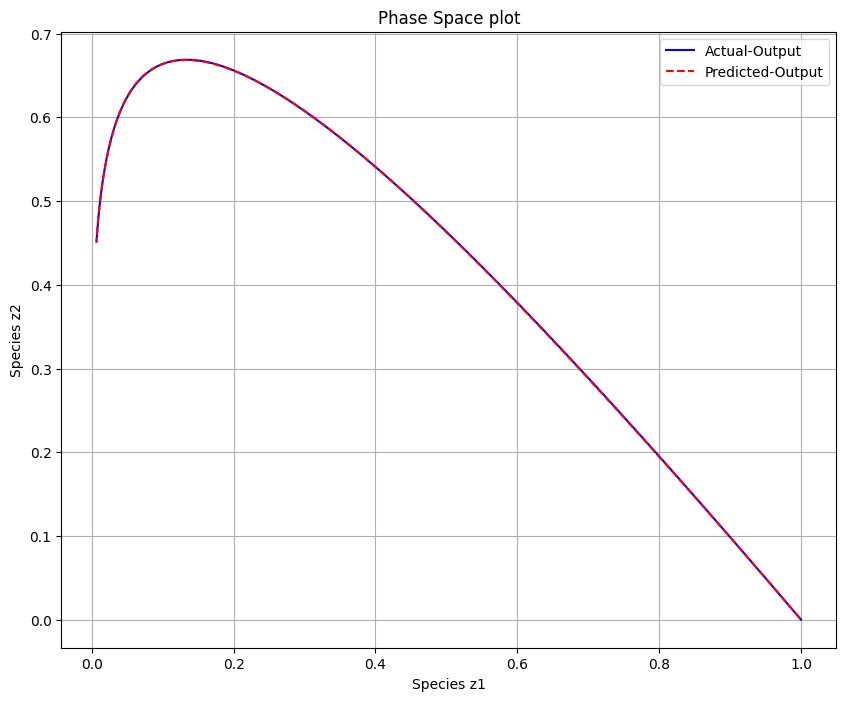

In [13]:
plt.rcParams['figure.figsize'] = [10,8]
plt.plot(z1_data,z2_data,'b')
plt.plot(z1_pred,z2_pred,'r--')
plt.legend(["Actual-Output", "Predicted-Output"])
plt.xlabel('Species z1')
plt.ylabel("Species z2")
plt.grid(True)
plt.title("Phase Space plot")
plt.show()

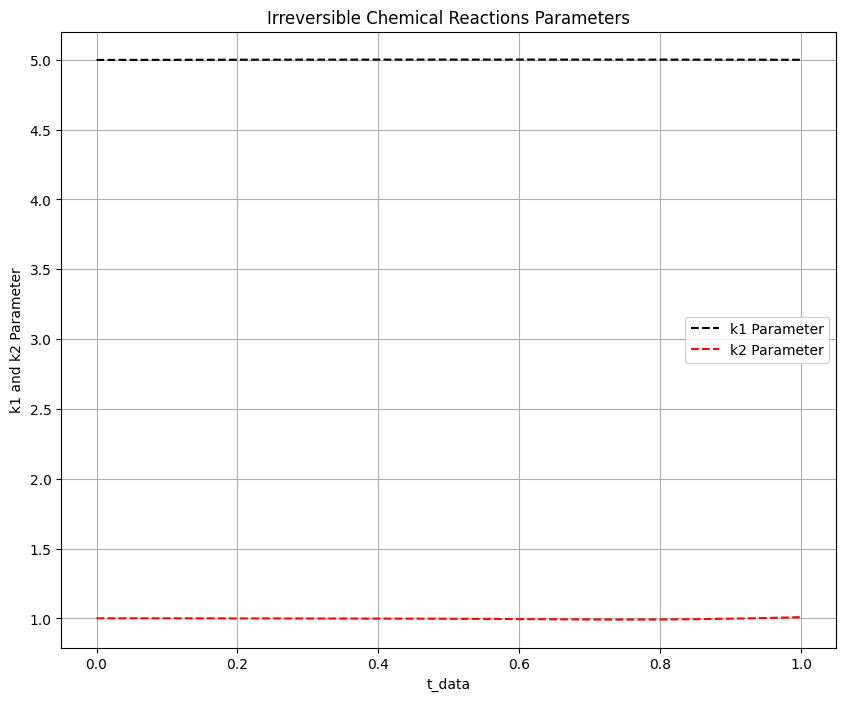

In [14]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,aa_pred,'k--')
plt.plot(t_data,bb_pred,'r--')

plt.xlabel('t_data')
plt.ylabel("k1 and k2 Parameter")
plt.legend(["k1 Parameter", "k2 Parameter"])
plt.grid(True)
plt.title("Irreversible Chemical Reactions Parameters")
  
plt.show()

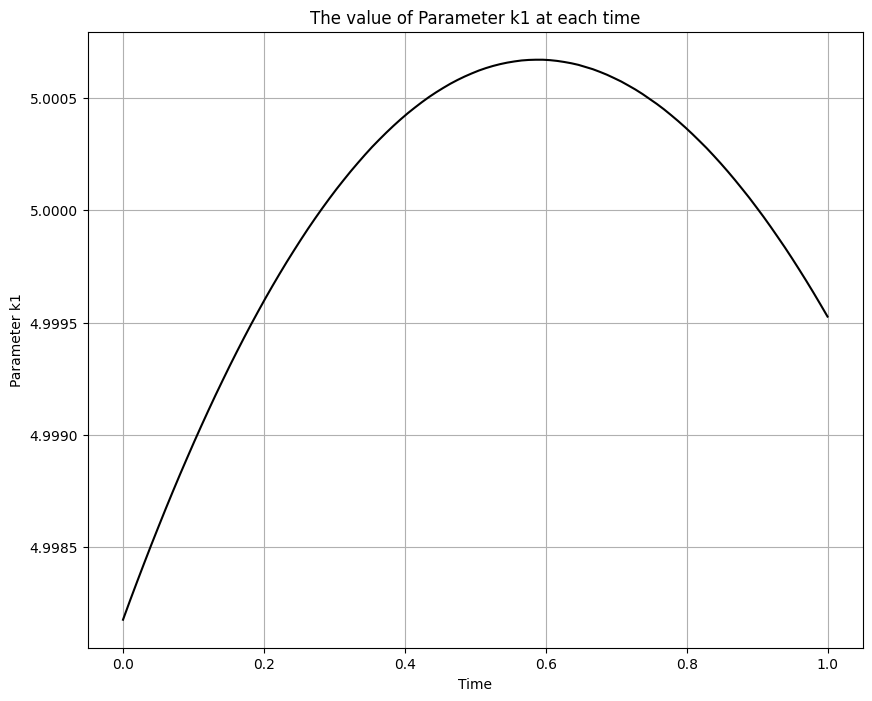

In [15]:
start_range = 0.0
end_range = 1.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
aa_pred_filtered = [aa_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, aa_pred_filtered, "k")
plt.xlabel('Time')
plt.ylabel('Parameter k1')
plt.grid(True)
plt.title('The value of Parameter k1 at each time')
plt.show()

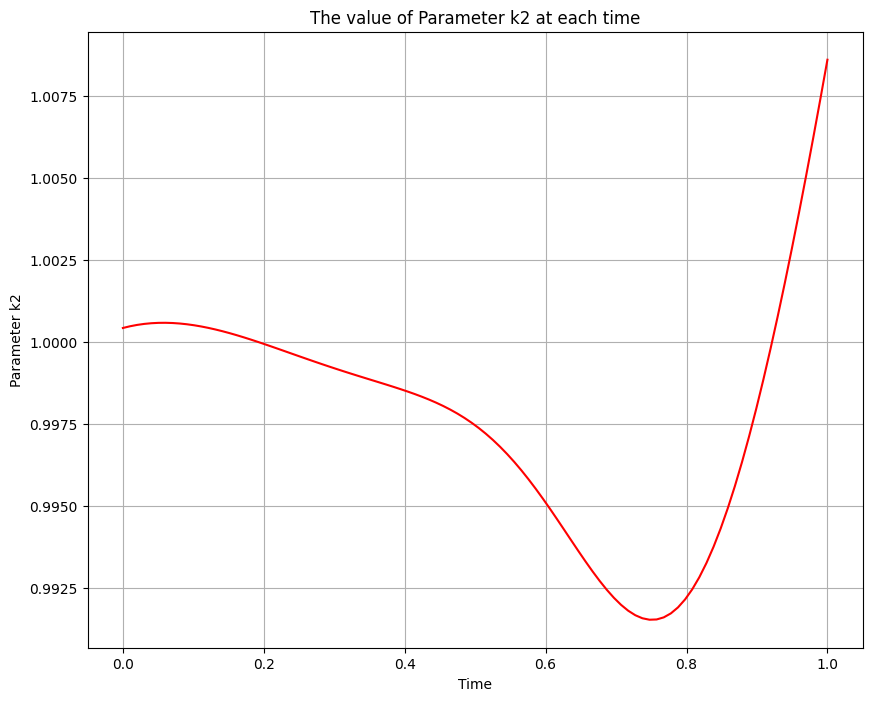

In [16]:
start_range = 0.0
end_range = 1.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
bb_pred_filtered = [bb_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, bb_pred_filtered, "r")
plt.xlabel('Time')
plt.ylabel('Parameter k2')
plt.grid(True)
plt.title('The value of Parameter k2 at each time')
plt.show()

In [17]:
import numpy as np

aa = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_preda = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_preda} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [5.0000086] at time step 28, which occurred at [0.28282828].


In [18]:
import numpy as np

bb = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.99999505] at time step 19, which occurred at [0.19191919].


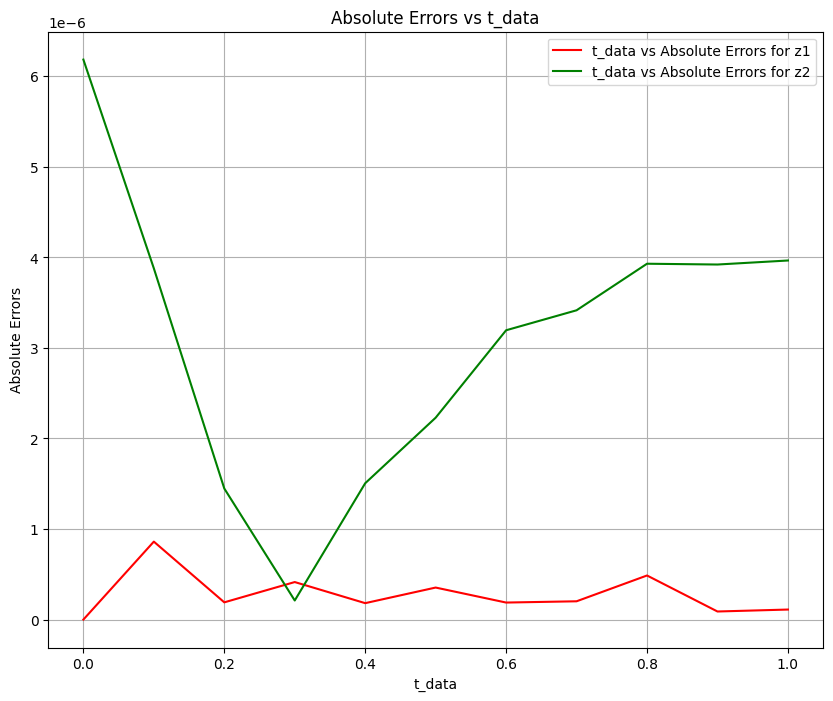

In [19]:
#from scipy.integrate import odeint

k1 = best_preda[0] # If best_preda is a one-dimensional array
k2 = best_predb[0]  # If best_predb is a one-dimensional array

t = np.array(dat1["t"]).flatten()

# Compute exact solutions with the learned parameters
u1_pred = np.exp(-k1 * t)  # use 't' instead of 't_fine'
u2_pred = 5 / 4 * np.exp(-k1 * t) * (-k2 + np.exp(4 * t))  # use 't' instead of 't_fine'


u1_u2 = np.hstack((z1_new, z2_new))



# plot the absolute errors between the target and the predictions (make sure u1_u2 and t are defined properly)
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_new, np.abs(u1_u2[:, 0] - u1_pred), 'r')
plt.plot(t_new, np.abs(u1_u2[:, 1] - u2_pred), 'g')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for z1", "t_data vs Absolute Errors for z2"])
plt.grid(True)
plt.title("Absolute Errors vs t_data")
plt.show()


Loss: 6.311349e-05


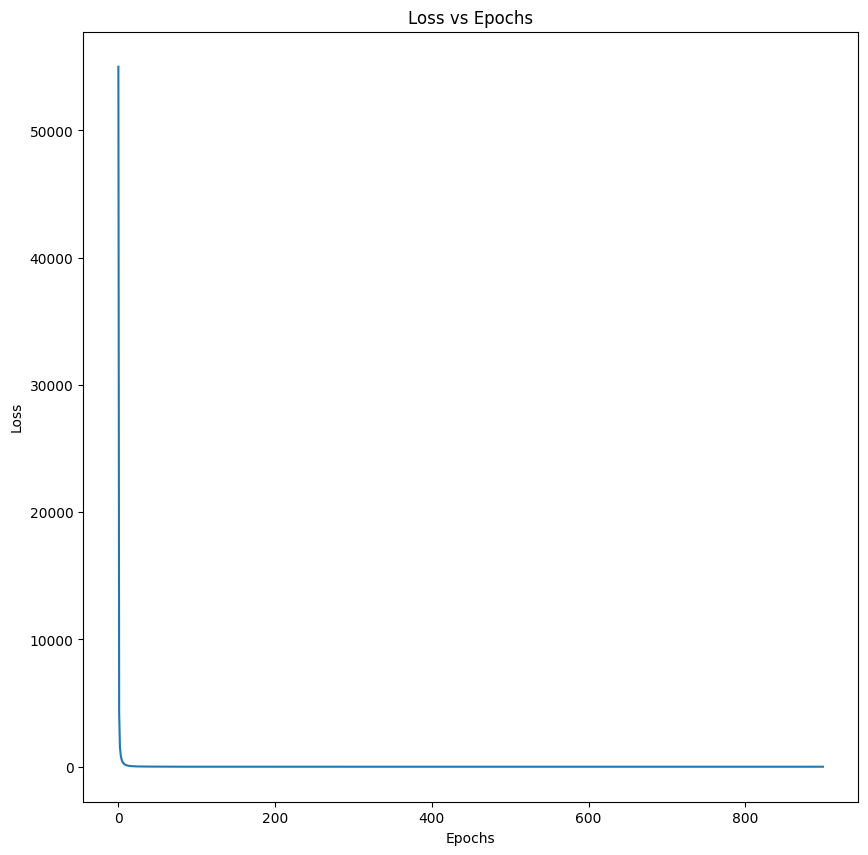

R-squared for u1: 0.9999999999985588
R-squared for u2: 0.9999999996454827
Mean absolute error for u1: 2.7978660886805035e-07
Mean absolute error for u2: 3.0801447826593482e-06
Mean squared error for u1: 1.3095315680440308e-13
Mean squared error for u2: 1.1915581925027157e-11
Root mean squared error for u1: 3.6187450421990646e-07
Root mean squared error for u2: 3.4518954104994488e-06
Explained variance score for u1: 0.999999999999209
Explained variance score for u2: 0.9999999996744908


In [20]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R-squared
from sklearn.metrics import r2_score
r2_u1 = r2_score(u1_u2[:, 0], u1_pred)
r2_u2 = r2_score(u1_u2[:, 1], u2_pred)
print(f"R-squared for u1: {r2_u1}")
print(f"R-squared for u2: {r2_u2}")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_u1 = mean_absolute_error(u1_u2[:, 0], u1_pred)
mae_u2 = mean_absolute_error(u1_u2[:, 1], u2_pred)
print(f"Mean absolute error for u1: {mae_u1}")
print(f"Mean absolute error for u2: {mae_u2}")

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_u1 = mean_squared_error(u1_u2[:, 0], u1_pred)
mse_u2 = mean_squared_error(u1_u2[:, 1], u2_pred)
print(f"Mean squared error for u1: {mse_u1}")
print(f"Mean squared error for u2: {mse_u2}")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_u1 = mean_squared_error(u1_u2[:, 0], u1_pred, squared=False)
rmse_u2 = mean_squared_error(u1_u2[:, 1], u2_pred, squared=False)
print(f"Root mean squared error for u1: {rmse_u1}")
print(f"Root mean squared error for u2: {rmse_u2}")

# calculate the Explained variance score
from sklearn.metrics import explained_variance_score
evs_u1 = explained_variance_score(u1_u2[:, 0], u1_pred)
evs_u2 = explained_variance_score(u1_u2[:, 1], u2_pred)
print(f"Explained variance score for u1: {evs_u1}")
print(f"Explained variance score for u2: {evs_u2}")


--------------

In [21]:
niter =  21378  # number of Epochs
layers = [1, 40, 2]
layers1 = [1, 40, 1]
layers2 = [1, 40, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2)
model.train(niter)


Device mapping: no known devices.


2023-08-08 11:22:51.177829: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 11:22:51.537178: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:22:51.537216: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:22:51.537221: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:22:51.537225: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

:0
Variable/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_5/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_5/A

100%|██████████| 21378/21378 [00:10<00:00, 2110.00it/s]


In [22]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred = model.predict(t_data)

In [23]:
import numpy as np

aa = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [4.99815] at time step 80, which occurred at [0.80808081].


In [24]:
import numpy as np

bb = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.0002131] at time step 0, which occurred at [0.].


Loss: 0.000833254


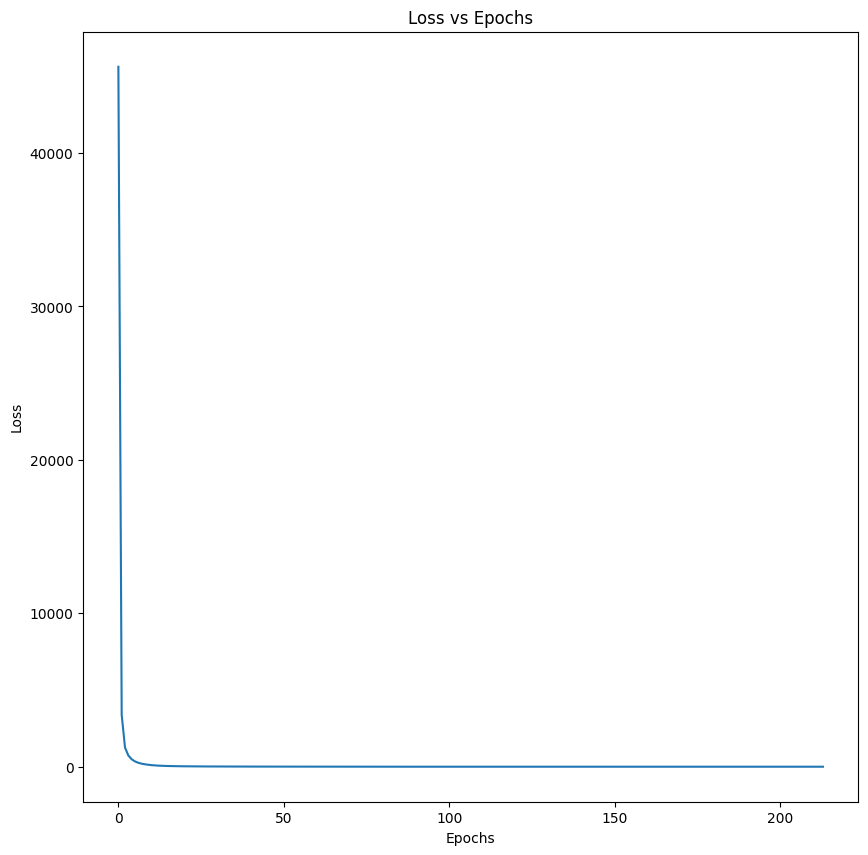

R^2 score for z1: 0.9999703695570491
R^2 score for z2: 0.9999001402134823
MSE for z1: 1.879945933636571e-06
MSE for z2: 2.0018727203991693e-06
MAE for z1: 0.0011866035724407212
MAE for z2: 0.00105896328374222
EVS for z1: 0.999971096570505
EVS for z2: 0.9999008624177779
RMSE for z1: 0.0013711112039643506
RMSE for z2: 0.0014148755140997987


In [25]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)


# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)


In [26]:
Error_prey = np.abs(z1_data - z1_pred)
Error_prey[-1]

array([0.00308206])

In [27]:
Error_prey = np.abs(z2_data - z2_pred)
Error_prey[-1]

array([0.00194101])

---------

In [28]:
niter =  24358  # number of Epochs
layers = [1, 40, 40, 2]
layers1 = [1, 40, 40, 1]
layers2 = [1, 40, 40, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2)
model.train(niter)


Device mapping: no known devices.


2023-08-08 11:23:02.025605: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 11:23:02.409775: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:02.409811: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:02.409821: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:02.409827: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

trided_slice_7_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_7_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_7_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_6_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_6_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_6_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_4_grad/StridedSliceGrad/begin: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_4_grad/StridedSliceGrad/end: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/strided_slice_4_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_5/st

100%|██████████| 24358/24358 [00:13<00:00, 1841.78it/s]


In [29]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred = model.predict(t_data)

In [30]:
import numpy as np

aa = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [5.0000534] at time step 0, which occurred at [0.].


In [31]:
import numpy as np

bb = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.0000036] at time step 21, which occurred at [0.21212121].


Loss: 3.4108365e-05


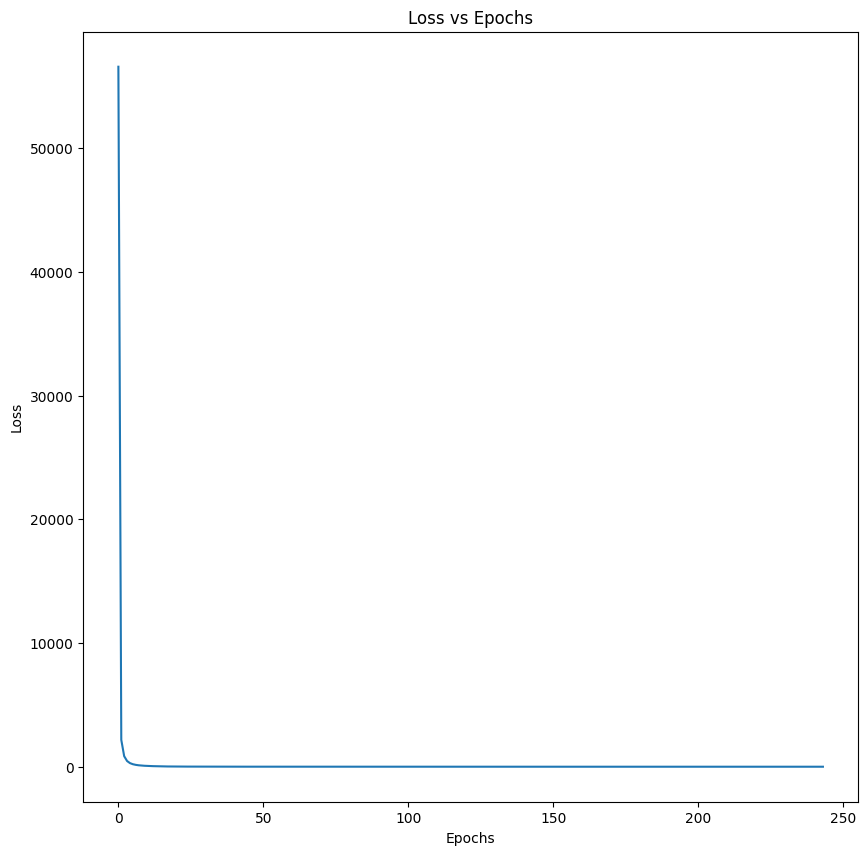

R^2 score for z1: 0.9999993633780058
R^2 score for z2: 0.9999955978382432
MSE for z1: 4.0391395140480114e-08
MSE for z2: 8.824941289247774e-08
MAE for z1: 0.0001677371338650765
MAE for z2: 0.0002131997427449419
EVS for z1: 0.999999373319871
EVS for z2: 0.9999956026927966
RMSE for z1: 0.00020097610589440754
RMSE for z2: 0.0002970680273817392


In [32]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)


# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)


-----

In [33]:
niter =  16021  # number of Epochs
layers = [1, 40, 40, 40, 2]
layers1 = [1, 40, 40, 40, 1]
layers2 = [1, 40, 40, 40, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2)
model.train(niter)


Device mapping: no known devices.


2023-08-08 11:23:16.028509: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 11:23:16.425319: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:16.425352: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:16.425357: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 11:23:16.425361: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

): /job:localhost/replica:0/task:0/device:CPU:0
Variable_32/Adam_1/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_36/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_36/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_37/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_37/Adam_1/Initializer/zeros

100%|██████████| 16021/16021 [00:09<00:00, 1686.58it/s]


In [34]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred = model.predict(t_data)

In [35]:
import numpy as np

aa = 5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [4.999991] at time step 84, which occurred at [0.84848485].


In [36]:
import numpy as np

bb = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.9999847] at time step 2, which occurred at [0.02020202].


Loss: 0.0006856894


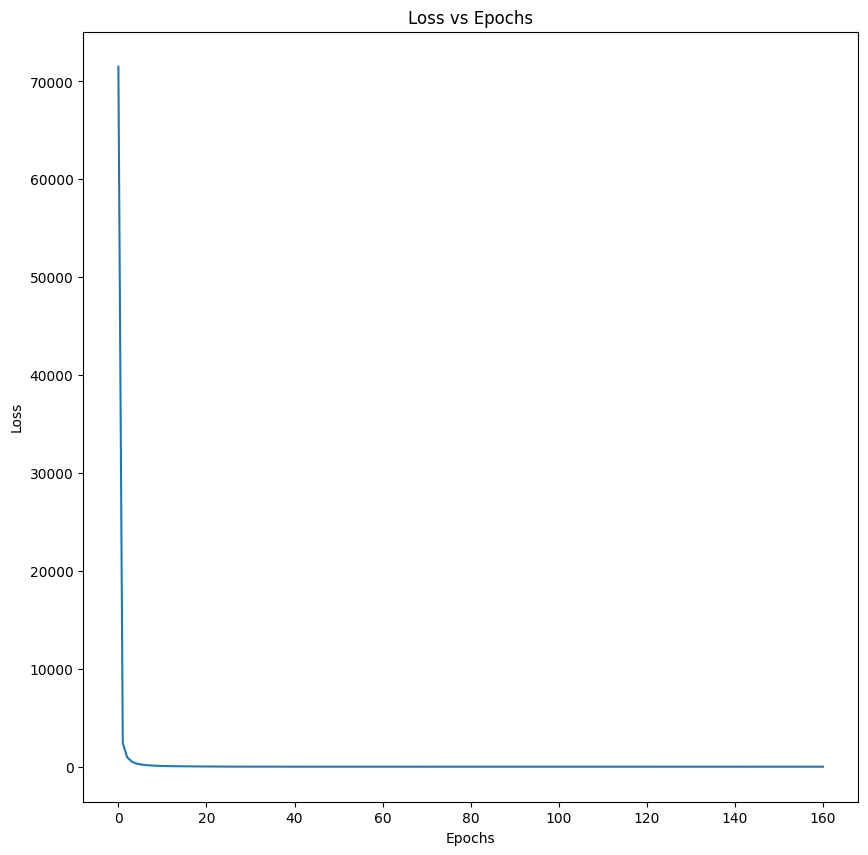

R^2 score for z1: 0.9999722674000276
R^2 score for z2: 0.999922152086298
MSE for z1: 1.759534564963766e-06
MSE for z2: 1.5606043254690147e-06
MAE for z1: 0.0012640327059088815
MAE for z2: 0.0011268720001175784
EVS for z1: 0.9999974505125983
EVS for z2: 0.9999801149920095
RMSE for z1: 0.00132647448711378
RMSE for z2: 0.0012492415000587415


In [37]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)


# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)
